In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy
import scipy.signal
import networkx as nx
import pandas as pd
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

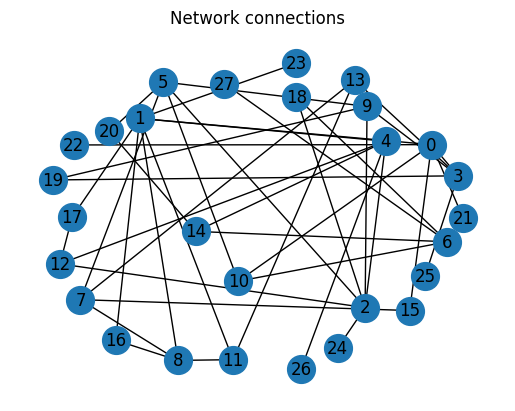

In [3]:
adj_mat = pd.read_csv('./ex5_files/Topology.dat', delim_whitespace=True, header=None)
rows, cols = np.where(adj_mat == 1)
edges = zip(rows.tolist(), cols.tolist())

gr = nx.Graph()
gr.add_edges_from(edges)

plt.title("Network connections")
pos = nx.spring_layout(gr, k=2.2) # Increase k value to increase spacing between nodes
nx.draw(gr, node_size=400, with_labels=True, pos=pos)
plt.show()

Calculate the degree distribution of the structural network:


[6.0, 7.0, 6.0, 5.0, 5.0, 5.0, 4.0, 4.0, 4.0, 4.0, 3.0, 3.0, 3.0, 3.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


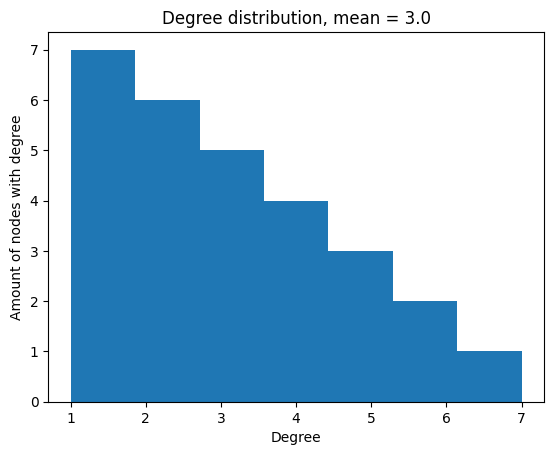

In [6]:
degrees = [sum(adj_mat[i]) for i in range(28)]
print(degrees)
plt.hist(degrees, 7)
plt.title("Degree distribution, mean = " + str(round(np.mean(degrees),2)))
plt.xlabel("Degree")
plt.ylabel("Amount of nodes with degree")
plt.show()

In [5]:
def pearson(s1, s2, lag=0) -> float:
    N = len(s1)
    return 1/(N-lag) * abs(sum([s1[k+lag] * s2[k] for k in range(1, N+lag)]))

Now we want to standardize the time series so that std(ts) = 1 and mean(ts) = 0:

In [194]:
def pearson_table_from_file(number: int):
    file_path = f"./ex5_files/TS_{str(number).zfill(2)}.dat"
    db = np.transpose(np.loadtxt(file_path))
    size = np.size(db, 0)
    table = np.empty((28,28))
    db1 = [(db[i] - np.mean(db[i]))/np.std(db[i]) for i in range(size)] #Standardizes the time series data column-wise
    column_indices = np.hstack([[i for i in range(0,j)] for j in range(1,28)])
    row_indices = np.hstack([[i]*i for i in range(1,28+1)])
    for row, col in zip(row_indices, column_indices):
        table[row, col] = pearson(db1[row], db1[col])
    return table
    #Combinatorically calculates the pearson coefficient and returns the lower triangle of a 28*28 matrix

b = pearson_table_from_file(5)


In [195]:
all_raw_data = [pearson_table_from_file(k) for k in range(25)]

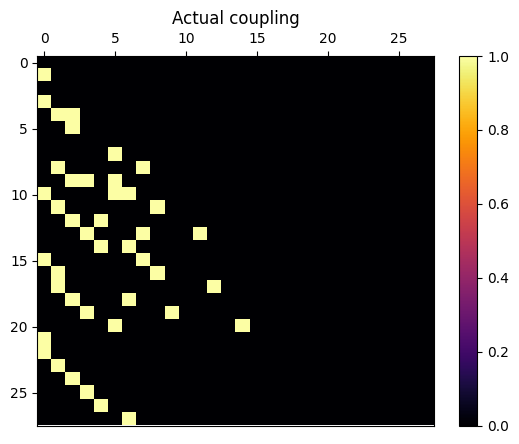

In [197]:
fig, ax = plt.subplots()
im = ax.imshow(np.tril(adj_mat)+np.zeros((28,28)), cmap='inferno', aspect='auto')

# Show all ticks and label them with the respective list entries
ax.xaxis.tick_top()
ax.set_title("Actual coupling")
fig.colorbar(im)
plt.show()

This calculates a heatmap for every measurement. This is akin to 25 x-y-heatmaps stacked on top of each other in the z-axis. We now want to "flatten" this stack by averaging the cell values along the z-axis:

In [ ]:
heatmap_data = np.mean(all_raw_data, axis=0)


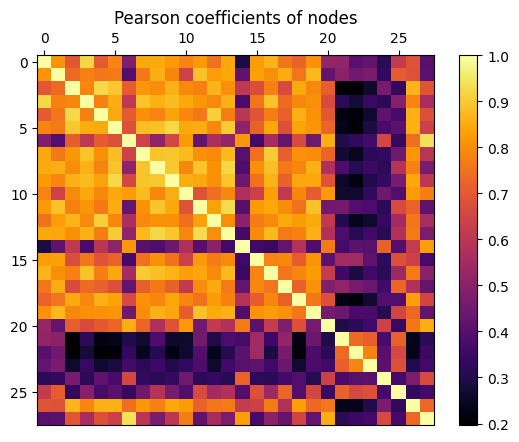

In [107]:
shaped_data = (np.tril(heatmap_data) + np.triu(heatmap_data.T, 1)) + np.identity(28)

fig, ax = plt.subplots()
im = ax.imshow(shaped_data, cmap='inferno', aspect='auto')

# Show all ticks and label them with the respective list entries
ax.xaxis.tick_top()
ax.set_title("Pearson coefficients of nodes")
fig.colorbar(im)
plt.show()

Reconstruct the network using the Pearson coefficient as a statistical similarity measure, keeping only the 10% strongest links:

In [133]:
# Flatten the matrix and sort in descending order
flattened = heatmap_data.flatten()
sorted_indices = np.argsort(flattened)[::-1]  # Reverse order to get highest values first

num_elem = 27*28/2 # Equal to 1+2+3+...+26+27
num_top_values = int((num_elem * 0.1))

# Get the indices of the top 10% highest values
top_10p_indices = np.unravel_index(sorted_indices[:num_top_values], heatmap_data.shape)
print(top_10p_indices)



(array([ 0, 27, 13,  9,  4,  3, 13, 12, 16, 13,  5,  9, 13,  9, 11,  7,  8,
       11, 19, 16,  8, 16,  7, 10,  9, 13, 16, 19, 12, 26, 16, 16, 19, 26,
       19, 18, 13]), array([ 3,  6, 11,  5,  2,  0,  8,  4,  7,  5,  2,  8,  9,  7,  8,  3,  7,
        1, 11,  3,  5,  8,  5,  7,  3,  7, 13,  1,  2,  2,  9,  0,  8,  4,
       13,  4,  3]))


Recalculate the correlation matrix with the top 10% strongest connections:

(37, 2)


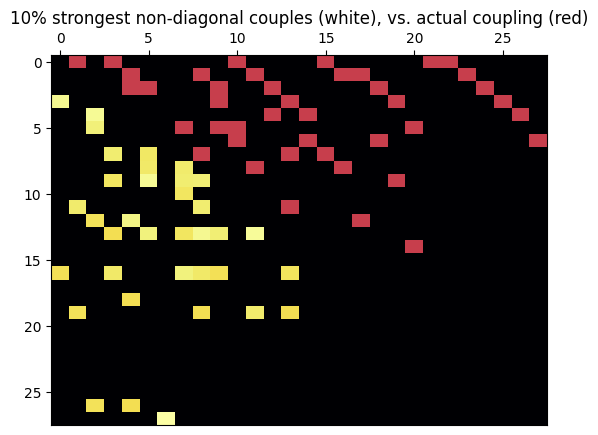

In [206]:

removed_heatmap_data = np.copy(heatmap_data)
row_indices = np.hstack([[i]*i for i in range(1,28+1)])
column_indices = np.hstack([[i for i in range(0,j)] for j in range(1,28)])
for row, col in zip(row_indices, column_indices):
    if [row, col] not in list(map(list, zip(*top_10p_indices))):
        removed_heatmap_data[row][col] = 0

# Reshape the data to again fit the triangular region
shaped_data = (np.tril(removed_heatmap_data) + np.triu(adj_mat)*0.5) 

fig, ax = plt.subplots()
im = ax.imshow(shaped_data, cmap='inferno', aspect='auto')

# Show all ticks and label them with the respective list entries
ax.xaxis.tick_top()
ax.set_title("10% strongest non-diagonal couples (white), vs. actual coupling (red)")
plt.show()



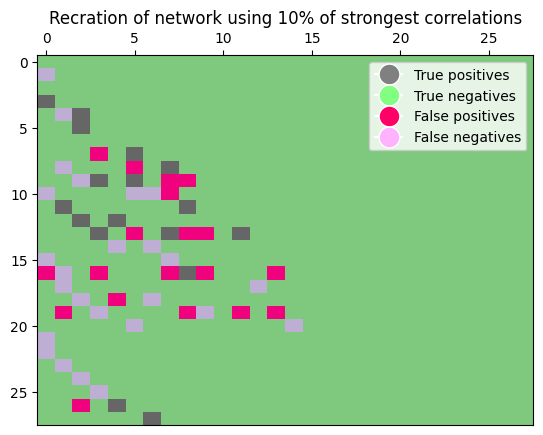

In [243]:
true_positives = (np.tril(removed_heatmap_data) + np.tril(adj_mat)*0.3 + np.zeros((28,28))) 

fig, ax = plt.subplots()
im = ax.imshow(true_positives, cmap='Accent', aspect='auto')

legend_elements = [Line2D([0], [0], marker='o', color='w', label='True positives',markerfacecolor='gray', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='True negatives',markerfacecolor='#80ff80', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='False positives',markerfacecolor='#ff0066', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='False negatives',markerfacecolor='#ffb3ff', markersize=15),]


# Create the figure
ax.legend(handles=legend_elements, loc='upper right')

# Show all ticks and label them with the respective list entries
ax.xaxis.tick_top()
ax.set_title("Recration of network using 10% of strongest correlations")
plt.show()

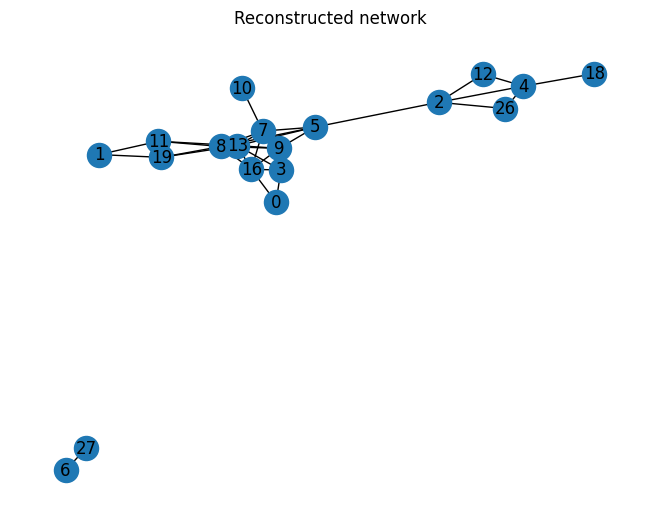

In [193]:
edges = zip(top_10p_indices[0].tolist(), top_10p_indices[1].tolist())
gr = nx.Graph()
gr.add_edges_from(edges)
nx.draw(gr, node_size=300, with_labels=True)
plt.title("Reconstructed network")
plt.show()

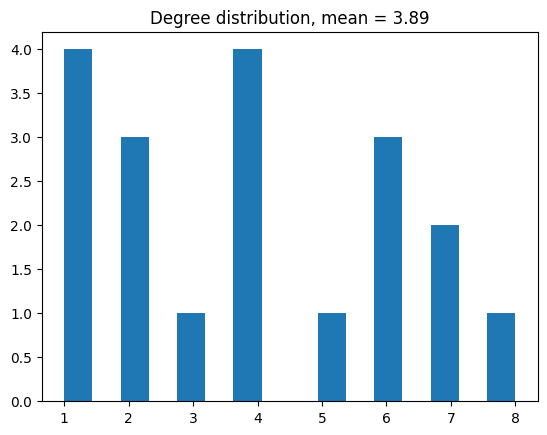

In [163]:
node_incidences = np.array(top_10p_indices).flatten()
nodes_in_network = np.unique(node_incidences)
degrees = [np.count_nonzero(node_incidences == i) for i in nodes_in_network]
plt.hist(degrees, 16)
plt.title("Degree distribution, mean = " + str(round(np.mean(degrees),2)))
plt.show()


Reconstruct the network using the threshold condition Pearson>0.5:

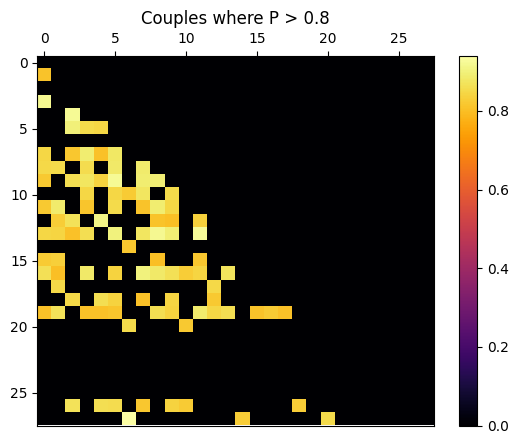

3.5357142857142856

In [211]:
def degree_from_Pearson(Pearson: float, plot = False) -> float:
    removed_heatmap_data = np.copy(heatmap_data)
    removed_heatmap_data[removed_heatmap_data < Pearson] = 0
    shaped_data = (np.tril(removed_heatmap_data)) 
    degrees = [np.count_nonzero(i) for i in removed_heatmap_data]

    if plot:
        fig, ax = plt.subplots()
        im = ax.imshow(shaped_data, cmap='inferno', aspect='auto')
        ax.xaxis.tick_top()
        ax.set_title("Couples where P > " + str(Pearson))
        fig.colorbar(im)
        plt.show()
    
    return np.mean(degrees)

degree_from_Pearson(0.8, True)

100


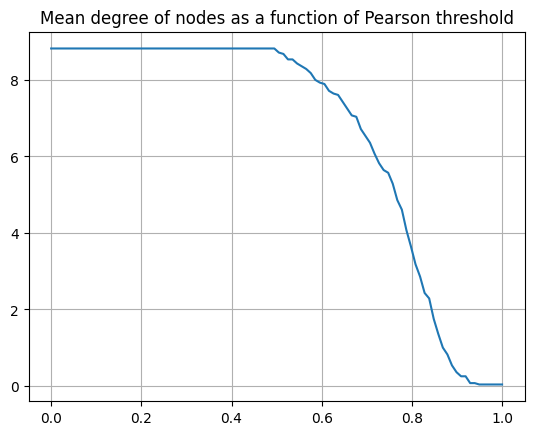

In [212]:
P_range = np.linspace(0,1,100)
degree_distribution = [degree_from_Pearson(P) for P in P_range]
print(len(degree_distribution))
plt.plot(P_range, degree_distribution)
plt.title("Mean degree of nodes as a function of Pearson threshold")
plt.grid()
plt.show()